In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [4]:
#load data 
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [5]:
sp500.head(5)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [6]:
sp500['Symbol'] = sp500['Symbol'].replace(".","-")
symbols_list = sp500['Symbol'].unique().tolist()
symbols_list

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BK',
 'BBWI',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BLDR',
 'BG',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CHRW',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA'

In [7]:
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)
df = yf.download(tickers=symbols_list,start=start_date,end=end_date).stack()
df.index.names = ['date','ticker']
df.columns = df.columns.str.lower()
df

[*********************100%%**********************]  503 of 503 completed

5 Failed downloads:
['VLTO', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-09-29 00:00:00 -> 2023-09-27)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483564   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334896   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547714  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[985131 rows x 6 columns]

In [8]:
#Calculate Garman_klass volatility,rsi(Relative Strength Index),bollinger band, ATR, MACD,Dollar Volume
import numpy as np
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x,length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,2])
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483564   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334896   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547714  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.054656        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146740  4.488345   
           YUM       1500600.0          0.000002  36.057165  4.816569   
           ZBH       3610500.0          0.000099  31.893238  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623488  5.156108   

Price                bb_mid   bb_high  
date       ticker                      
2015-09-29 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2023-09-26 XYL     4.570270  4.652196  
           YUM     4.846536  4.876502  
           ZBH     4.787752  4.827420  
           ZBRA    5.539167  5.677342  
           ZTS     5.214922  5.273735  

[985131 rows x 11 columns]

In [9]:
def compute_atr(stock_data): 
    atr = pandas_ta.atr(high=stock_data['high'],low=stock_data['low'],close=stock_data['close'],length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1,group_keys=False).apply(compute_atr)

In [10]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close,length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1,group_keys=False)['adj close'].apply(compute_macd)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483564   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334896   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547714  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.054656        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146740  4.488345   
           YUM       1500600.0          0.000002  36.057165  4.816569   
           ZBH       3610500.0          0.000099  31.893238  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623488  5.156108   

Price                bb_mid   bb_high       atr      macd  
date       ticker                                          
2015-09-29 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2023-09-26 XYL     4.570270  4.652196  0.033800 -2.159188  
           YUM     4.846536  4.876502  0.142547 -1.363695  
           ZBH     4.787752  4.827420 -0.381708 -0.881067  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791  
           ZTS     5.214922  5.273735  0.651515 -1.188278  

[985131 rows x 13 columns]

In [11]:
df['dollar volume'] = (df['adj close']*df['volume'])/1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483564   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334896   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547714  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.054656        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146740  4.488345   
           YUM       1500600.0          0.000002  36.057165  4.816569   
           ZBH       3610500.0          0.000099  31.893238  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623488  5.156108   

Price                bb_mid   bb_high       atr      macd  dollar volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.913580  
           AAL          NaN       NaN       NaN       NaN     279.420040  
           AAPL         NaN       NaN       NaN       NaN    7243.972939  
           ABBV         NaN       NaN       NaN       NaN     466.641803  
           ABT          NaN       NaN       NaN       NaN     411.369604  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.570270  4.652196  0.033800 -2.159188     117.651922  
           YUM     4.846536  4.876502  0.142547 -1.363695     184.291052  
           ZBH     4.787752  4.827420 -0.381708 -0.881067     403.591519  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.214922  5.273735  0.651515 -1.188278     256.861415  

[985131 rows x 14 columns]

In [12]:
#Aggreagate and filter the top 150 liquid stocks monthly to reduce the features for training
#for dollar volume 
#to aggregate the other features
last_cols = [ c for c in df.columns.unique(0) if c not in ['dollar volume','high','low','close','open','volume']]
last_cols

data = (pd.concat([df.unstack('ticker')['dollar volume'].resample('M').mean().stack('ticker').to_frame('dollar volume'),df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1)).dropna()
data

dollar volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.992837   39.023182         -0.001992  73.421452   
           AAL        287.915809   39.429928         -0.000966  40.718949   
           AAPL      4029.441910   26.890564         -0.003209  55.537371   
           ABBV       337.563928   40.393536         -0.059549  49.376885   
           ABT        211.659052   38.293575         -0.011216  56.962671   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.983159   78.671936         -0.000020  33.116246   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.971017  108.026909          0.000171  55.245466   
           GEHC       212.275851   66.130211          0.000185  40.922312   
           KVUE       677.910279   20.218124          0.000032  35.706310   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.545992  3.618440  3.690888 -1.033887  0.567157  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418772  
           AAPL    3.282983  3.326297  3.369611 -0.967900 -0.142789  
           ABBV    3.726695  3.774943  3.823191 -0.526809  0.145678  
           ABT     3.656055  3.677909  3.699763 -1.064842  0.335558  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.374104  4.419394  4.464683 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.653660  4.693834  4.734007 -0.436215  0.366876  
           GEHC    4.155436  4.212972  4.270508 -0.893478 -1.116463  
           KVUE    3.024299  3.099281  3.174263 -0.899746 -1.435621  

[46514 rows x 9 columns]

In [13]:
#calculate the 5 year rolling average of dollar volume fro each stock before filtering
data['dollar volume'] = (data.loc[:,'dollar volume'].unstack('ticker').rolling(5*12,min_periods=12).mean().stack())
data['dollar volume rank'] = data.groupby('date')['dollar volume'].rank(ascending=False)
data = data[data['dollar volume rank']<150].drop(['dollar volume','dollar volume rank'],axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134335         -0.000176  62.203557  3.604673   
           AAPL     26.248028         -0.002384  49.891090  3.295542   
           ABBV     40.245117         -0.046691  27.477717  3.753446   
           ABT      34.293457         -0.007492  38.008890  3.554632   
           ACN     103.569626         -0.004643  53.823660  4.637342   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.783062         -0.000011  54.722560  3.988367   
           XOM     114.292961          0.000026  59.440186  4.695106   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655494  3.706314  0.402199  1.131596  
           AAPL    3.324423  3.353305 -1.038688 -0.195978  
           ABBV    3.807610  3.861774 -0.893132 -0.760594  
           ABT     3.605106  3.655580 -1.035224 -0.650889  
           ACN     4.648980  4.660617 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 WMT     4.005838  4.023309 -0.196381  0.399459  
           XOM     4.735205  4.775304  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

In [14]:
#calculate monthly returns of different time horizons 
#first case study: AAPL stock
def investment_returns(stock):
    lags = [1,2,3,6,9,12]
    outlier_cutoff = 0.005
    for lag in lags:
        stock[f'return {lag} m'] = (stock['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1))
    return stock

data = data.groupby(level=1,group_keys=False).apply(investment_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534168         -0.000363  41.051806  3.849110   
           AAPL     39.767769         -0.000998  69.196792  3.596048   
           ABBV     67.491158         -0.034008  55.247903  4.196702   
           ABT      48.493374         -0.005190  53.844874  3.892568   
           ACN     129.399734         -0.003925  69.365236  4.802675   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.783062         -0.000011  54.722560  3.988367   
           XOM     114.292961          0.000026  59.440186  4.695106   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return 1 m  \
date       ticker                                                       
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018698   -0.014108   
           AAPL    3.642922  3.689797 -0.906642 -0.039275    0.096808   
           ABBV    4.243063  4.289423  0.375557  0.473815    0.022728   
           ABT     3.916137  3.939707 -1.040044  0.276133    0.021275   
           ACN     4.842354  4.882034 -0.986514  0.352343    0.064180   
...                     ...       ...       ...       ...         ...   
2023-09-30 WMT     4.005838  4.023309 -0.196381  0.399459   -0.000676   
           XOM     4.735205  4.775304  0.601335  1.400623    0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899   -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973   -0.062672   
           ABNB    4.940924  5.024801 -1.006939 -0.037854    0.005549   

                   return 2 m  return 3 m  return 6 m  return 9 m  return 12 m  
date       ticker                                                               
2017-10-31 AAL       0.022981   -0.023860    0.016495    0.007008     0.012702  
           AAPL      0.015250    0.044955    0.028875    0.038941     0.035228  
           ABBV      0.098590    0.091379    0.056495    0.047273     0.044026  
           ABT       0.034308    0.034801    0.038672    0.031320     0.029294  
           ACN       0.048454    0.037203    0.028692    0.027398     0.018728  
...                       ...         ...         ...         ...          ...  
2023-09-30 WMT       0.010014    0.012354    0.017574    0.016553     0.020256  
           XOM       0.046139    0.030496    0.012838    0.008747     0.027037  
           MRNA     -0.086803   -0.068763   -0.071952   -0.064976    -0.015431  
           UBER     -0.053920    0.008422    0.057244    0.066838     0.043691  
           ABNB     -0.067704    0.010603    0.010289    0.049124     0.019401  

[10342 rows x 14 columns]

In [15]:
#Introduce Fama-french factors (all 5 fama-french factors) and calculate rolling factor betas
factor_data = web.DataReader('F-F_Research_Data_5_factors_2x3','famafrench',start='2010')[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)#divide result by hundred
factor_data.index.name = 'date'
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2023-11-30,0.0884,-0.0012,0.0164,-0.0391,-0.0100
2023-12-31,0.0487,0.0732,0.0493,-0.0307,0.0132
2024-01-31,0.0071,-0.0574,-0.0238,0.0069,-0.0096


In [16]:
#join each factor to the public data 
#on the first month return 
factor_data = factor_data.join(data['return 1 m']).sort_index()

In [17]:
#filter stocks less than 10 month of data because our rolling window regression is for about 2 years which is 24 months
observation_data = factor_data.groupby(level=1).size()
valid_stocks = observation_data[observation_data>=10]

In [18]:
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return 1 m
date       ticker                                                    
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325   -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325    0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325    0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325    0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325    0.064180
...                   ...     ...     ...     ...     ...         ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083    0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083   -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083   -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083   -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083    0.046947

[10317 rows x 6 columns]

In [19]:
#calculate rolling factor beta for all our features
betas = (factor_data.groupby(level=1,group_keys=False).apply(lambda x: RollingOLS(endog=x['return 1 m'],exog=sm.add_constant(x.drop('return 1 m',axis=1)),window=min(24,x.shape[0]),min_nobs=len(x.columns)+1).fit(params_only=True).params.drop('const',axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332654 -0.165645  0.267343  0.310366  0.106903
           WFC     1.121746  0.300523  2.061531 -0.439487 -1.517555
           WMT     0.700557 -0.315600 -0.413434 -0.142907  0.508472
           XOM     0.983510 -1.093758  1.756777 -0.640865 -0.368455

[10317 rows x 5 columns]

In [20]:
#Join all features to data dataframe
#first we shift beta on a ticker level(level 1)
betas.groupby('ticker').shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.504874 -0.411220 -0.481330  0.057087  0.943374
           VZ      0.302530 -0.212072  0.344588  0.318168  0.000827
           WFC     1.137639  0.314484  2.009073 -0.404336 -1.468838
           WMT     0.740055 -0.261890 -0.522678 -0.126427  0.642629
           XOM     1.005967 -1.051369  1.707834 -0.675679 -0.284026

[10317 rows x 5 columns]

In [21]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']
data = (data.join(betas.groupby('ticker').shift()))
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close',axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10123 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10123 non-null  float64
 1   rsi               10123 non-null  float64
 2   bb_low            10123 non-null  float64
 3   bb_mid            10123 non-null  float64
 4   bb_high           10123 non-null  float64
 5   atr               10123 non-null  float64
 6   macd              10123 non-null  float64
 7   return 1 m        10123 non-null  float64
 8   return 2 m        10123 non-null  float64
 9   return 3 m        10123 non-null  float64
 10  return 6 m        10123 non-null  float64
 11  return 9 m        10123 non-null  float64
 12  return 12 m       10123 non-null  float64
 13  Mkt-RF            10123 non-null  float64
 14  SMB               10123 non-null  float64
 15  HML       

In [22]:
#To improve the graph accuracy and not have our inital centre as random we use the RSI as our constraints
#Hence, we improve our centroid by applying pre-defined cetroids
target_rsi_vlaues = [30,45,55,70]
initial_centroids = np.zeros((len(target_rsi_vlaues),18))
initial_centroids[:,1] = target_rsi_vlaues
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [23]:
#From here on we can use a machine learning model to determine which type of portfolio we'll need
#for the case study, however, we will use the long portfolio
#We can also predict the magnitude of each stock
#Clustering is adopted for this case study and we will need a number of 4 clusters for monthly stock grouping
from sklearn.cluster import KMeans
def get_cluster(df):
    df['cluster'] = KMeans(n_clusters=4,random_state=0,init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date',group_keys=False).apply(get_cluster)
# data = data.drop('cluster',axis=1)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051806  3.849110  3.921750  3.994389   
           AAPL           -0.000998  69.196792  3.596048  3.642922  3.689797   
           ABBV           -0.034008  55.247903  4.196702  4.243063  4.289423   
           ABT            -0.005190  53.844874  3.892568  3.916137  3.939707   
           ACN            -0.003925  69.365236  4.802675  4.842354  4.882034   
...                             ...        ...       ...       ...       ...   
2023-09-30 WFC             0.000016  40.920277  3.702645  3.743015  3.783384   
           WMT            -0.000011  54.722560  3.988367  4.005838  4.023309   
           XOM             0.000026  59.440186  4.695106  4.735205  4.775304   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   

                        atr      macd  return 1 m  return 2 m  return 3 m  \
date       ticker                                                           
2017-10-31 AAL     1.011062 -0.018698   -0.014108    0.022981   -0.023860   
           AAPL   -0.906642 -0.039275    0.096808    0.015250    0.044955   
           ABBV    0.375557  0.473815    0.022728    0.098590    0.091379   
           ABT    -1.040044  0.276133    0.021275    0.034308    0.034801   
           ACN    -0.986514  0.352343    0.064180    0.048454    0.037203   
...                     ...       ...         ...         ...         ...   
2023-09-30 WFC    -0.558742 -0.282325   -0.015500   -0.057917   -0.013554   
           WMT    -0.196381  0.399459   -0.000676    0.010014    0.012354   
           XOM     0.601335  1.400623    0.046947    0.046139    0.030496   
           MRNA   -0.529511 -0.376899   -0.132219   -0.086803   -0.068763   
           UBER   -0.746098 -0.133973   -0.062672   -0.053920    0.008422   

                   return 6 m  return 9 m  return 12 m    Mkt-RF       SMB  \
date       ticker                                                            
2017-10-31 AAL       0.016495    0.007008     0.012702  1.265664  1.314316   
           AAPL      0.028875    0.038941     0.035228  1.275750 -0.271695   
           ABBV      0.056495    0.047273     0.044026  0.494522  0.362282   
           ABT       0.038672    0.031320     0.029294  0.828091 -0.199022   
           ACN       0.028692    0.027398     0.018728  1.199048 -0.166701   
...                       ...         ...          ...       ...       ...   
2023-09-30 WFC       0.016712    0.000702     0.003255  1.137639  0.314484   
           WMT       0.017574    0.016553     0.020256  0.740055 -0.261890   
           XOM       0.012838    0.008747     0.027037  1.005967 -1.051369   
           MRNA     -0.071952   -0.064976    -0.015431  1.155154  0.762525   
           UBER      0.057244    0.066838     0.043691  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563293        1  
           AAPL   -0.591144  0.647780  0.458080        3  
           ABBV   -0.033101  0.241983  0.164918        2  
           ABT    -0.529385  0.252406  0.970212        2  
           ACN    -0.328214  0.267788  0.168883        3  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009073 -0.404336 -1.468838        1  
           WMT    -0.522678 -0.126427  0.642629        3  
           XOM     1.707834 -0.675679 -0.284026        3  
           MRNA   -1.165677  0.590306  0.993548        1  
           UBER   -0.257003 -1.482231 -0.450323        2  

[10123 rows x 19 columns]

In [24]:
#Plot a graph for all 4 clusters 
def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
    plt.scatter(cluster_0.iloc[:,0],cluster_0.iloc[:,1], color = 'red',label = 'cluster 0')
    plt.scatter(cluster_1.iloc[:,0],cluster_1.iloc[:,1], color = 'green',label = 'cluster 1')
    plt.scatter(cluster_2.iloc[:,0],cluster_2.iloc[:,1], color = 'blue',label = 'cluster 2')
    plt.scatter(cluster_3.iloc[:,0],cluster_3.iloc[:,1], color = 'black',label = 'cluster 3')
    plt.legend()
    plt.show()
    return

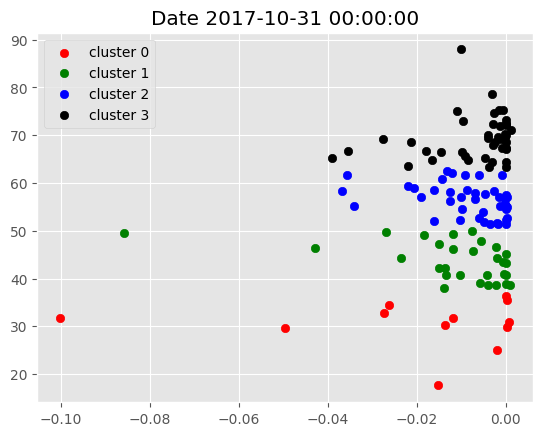

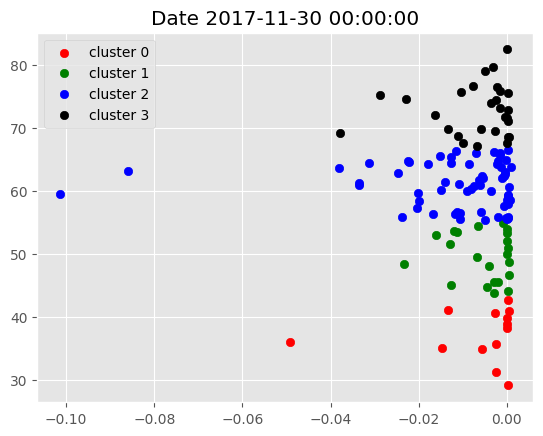

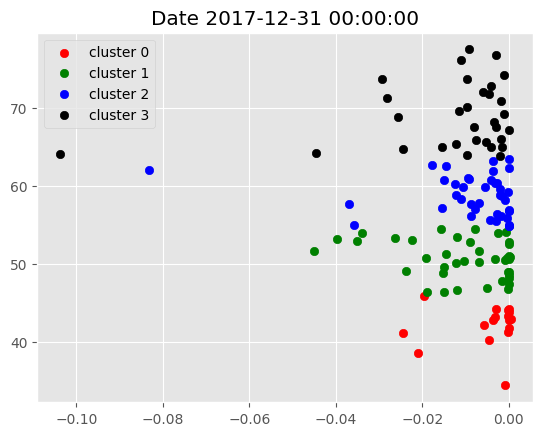

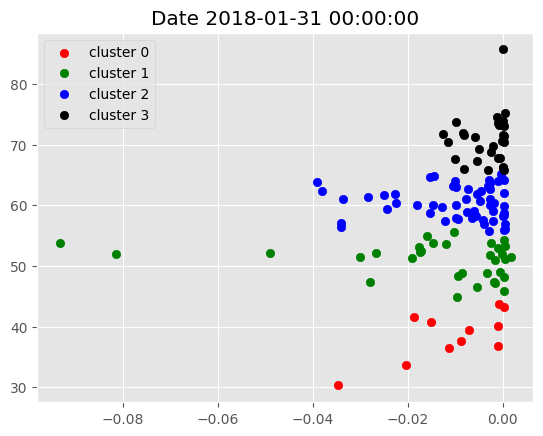

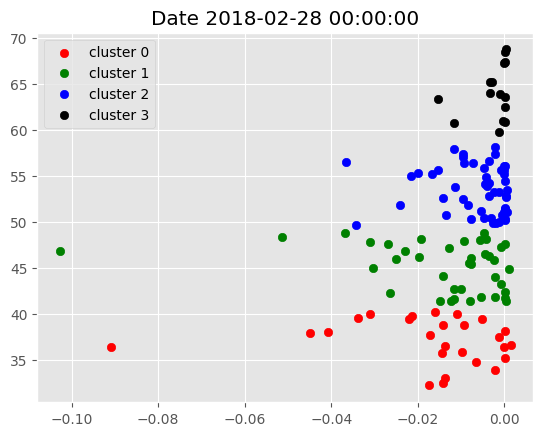

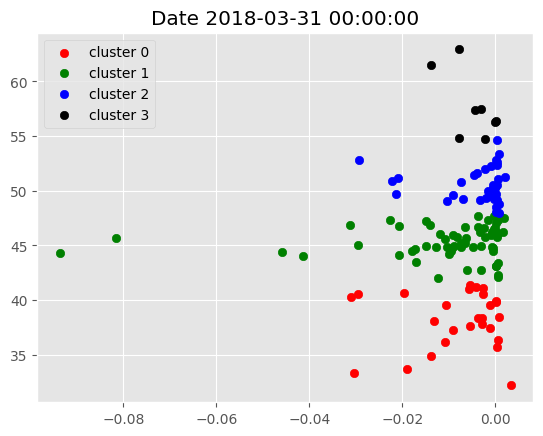

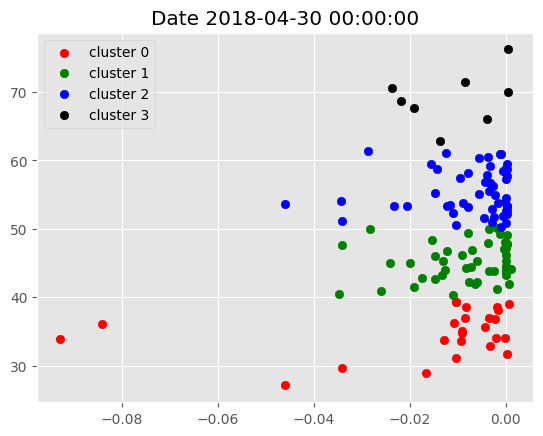

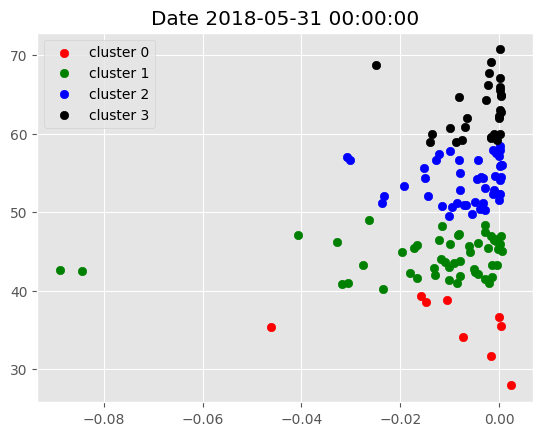

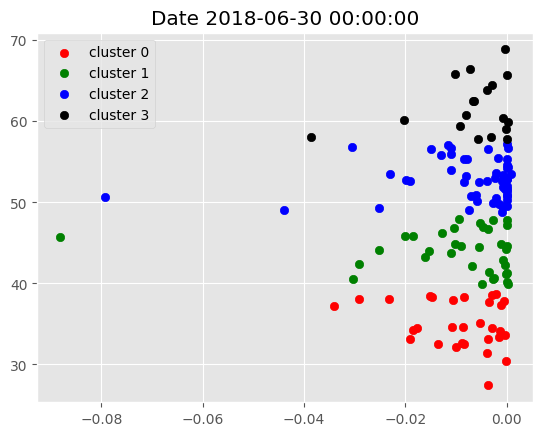

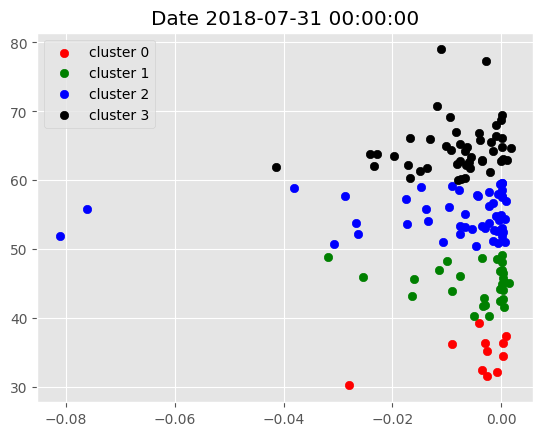

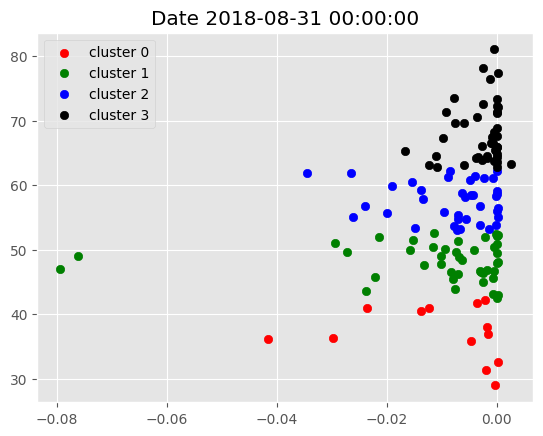

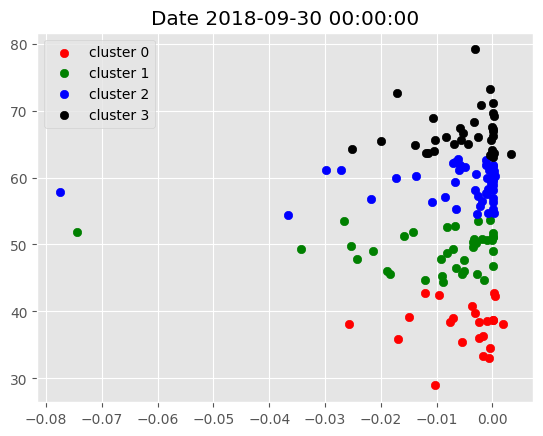

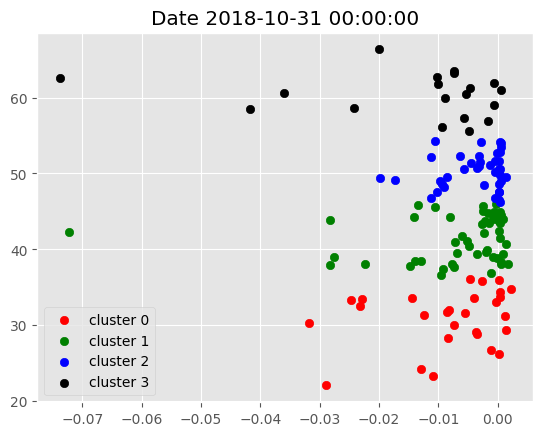

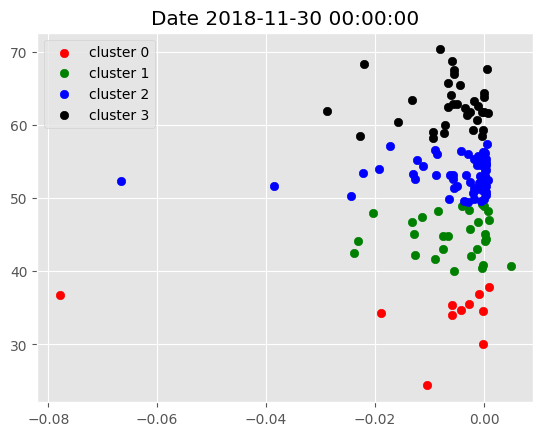

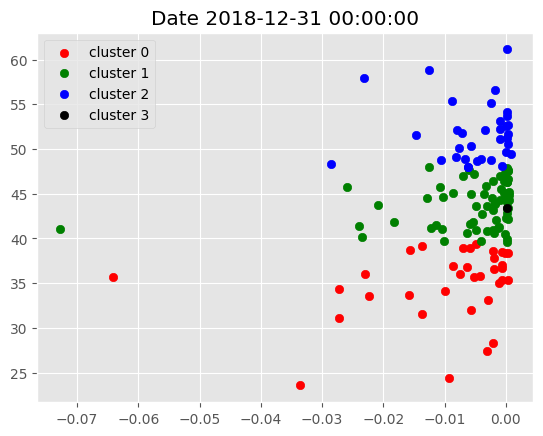

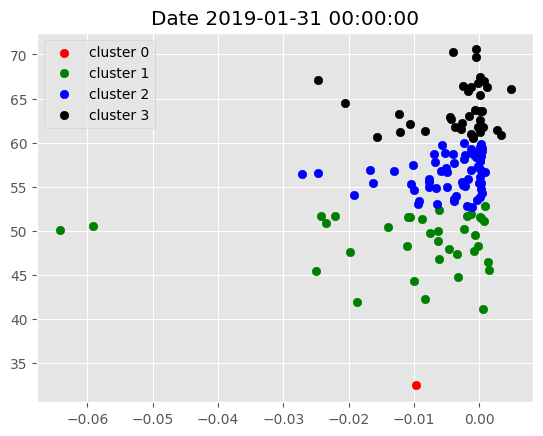

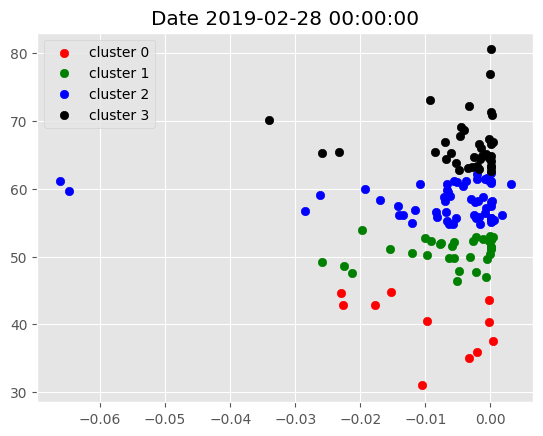

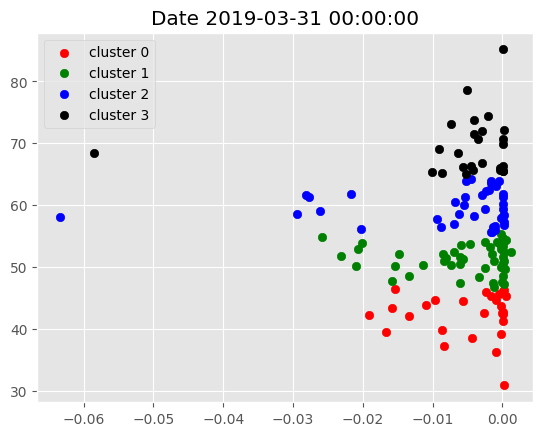

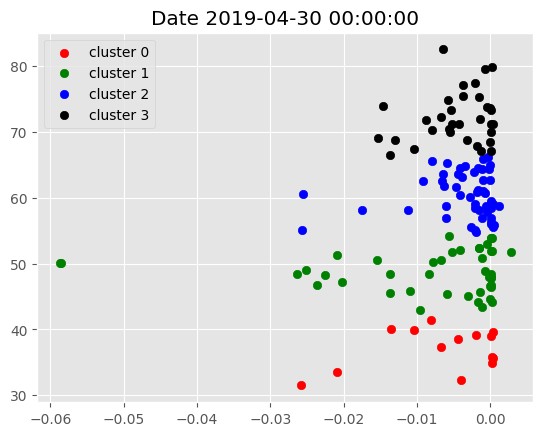

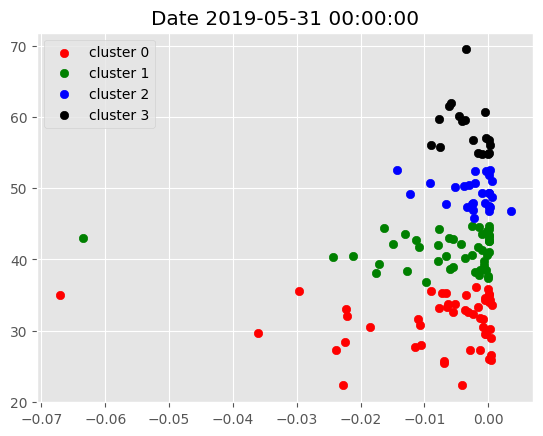

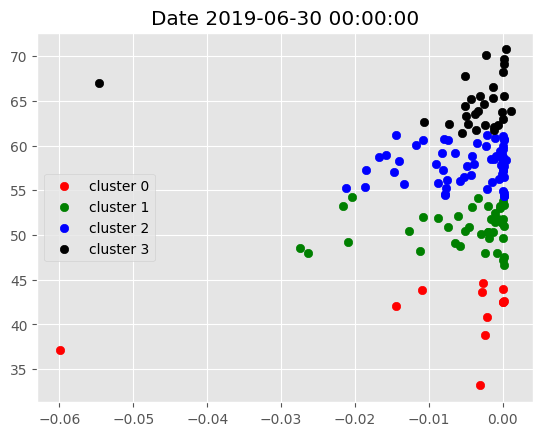

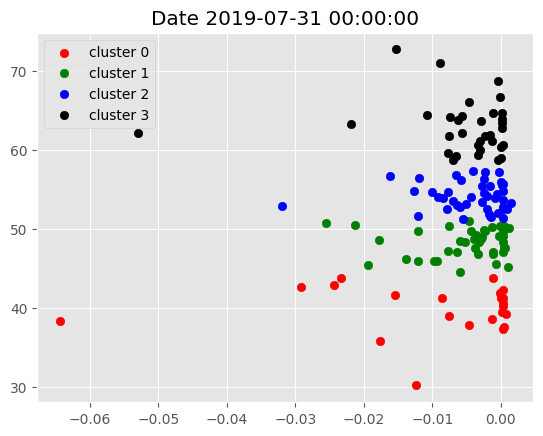

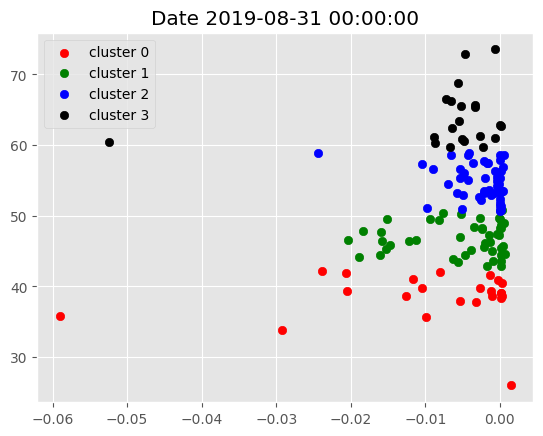

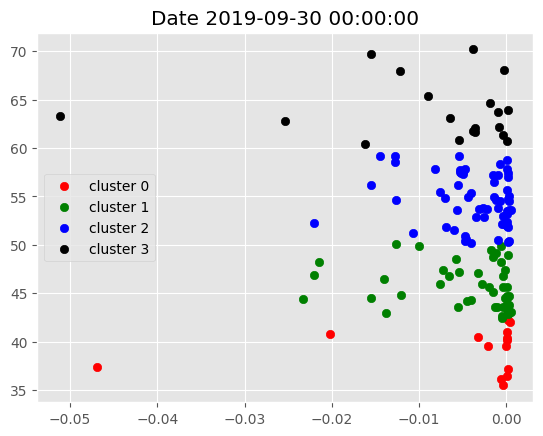

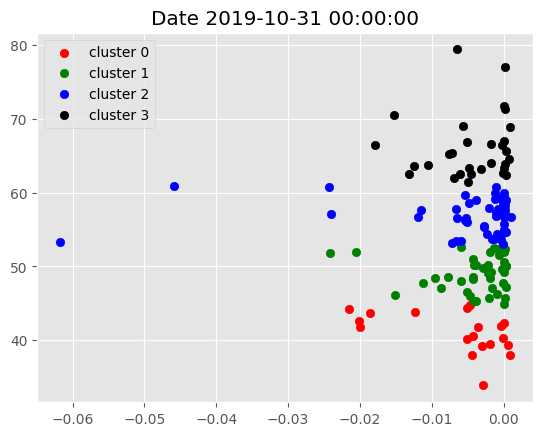

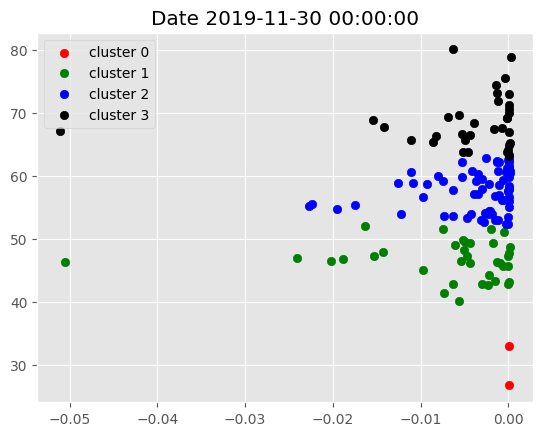

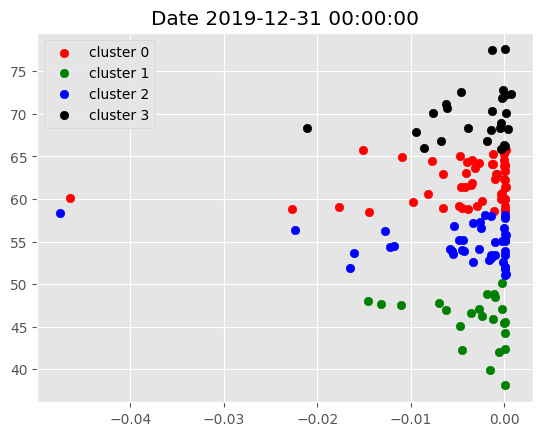

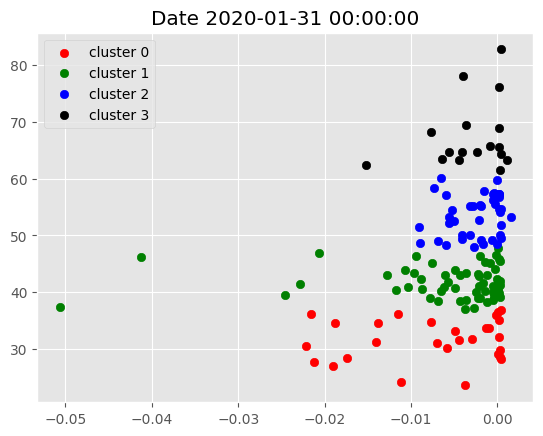

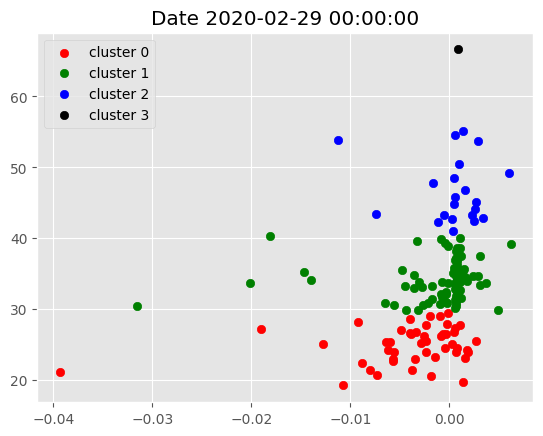

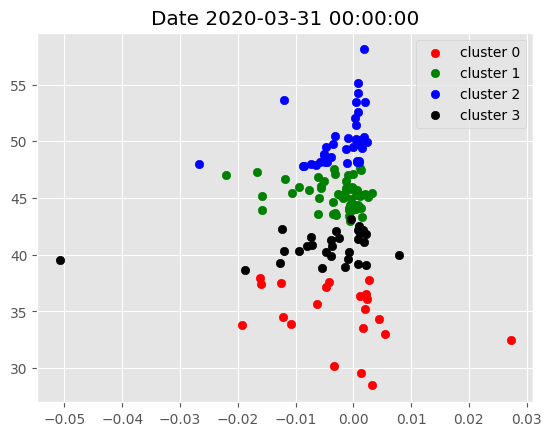

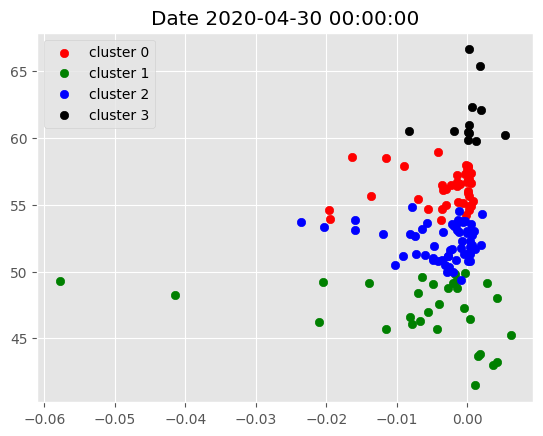

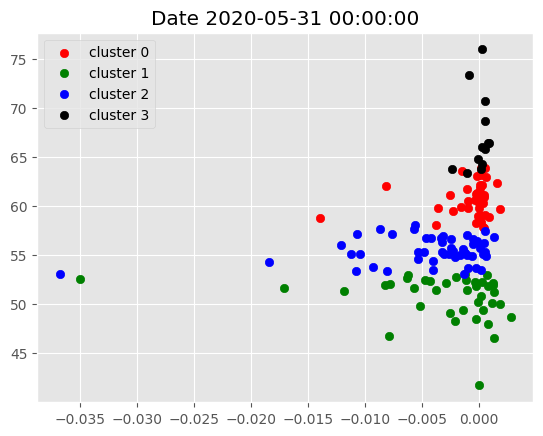

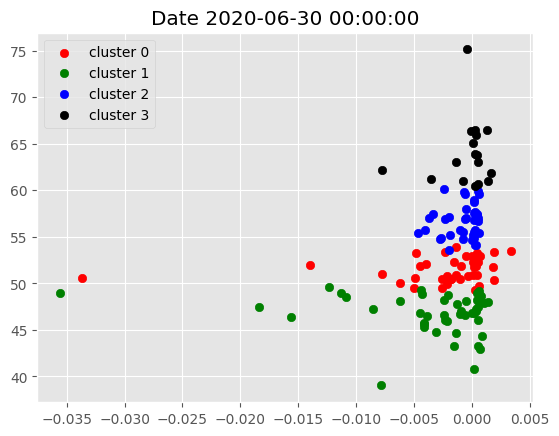

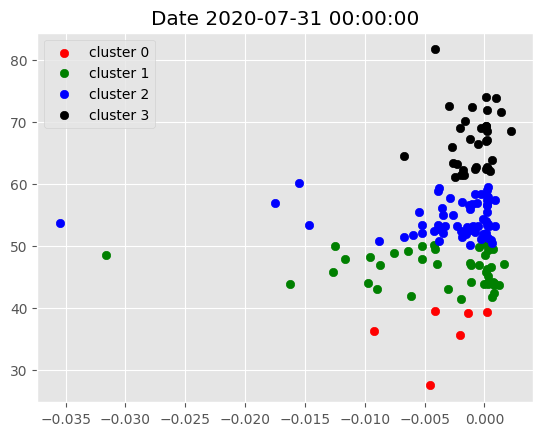

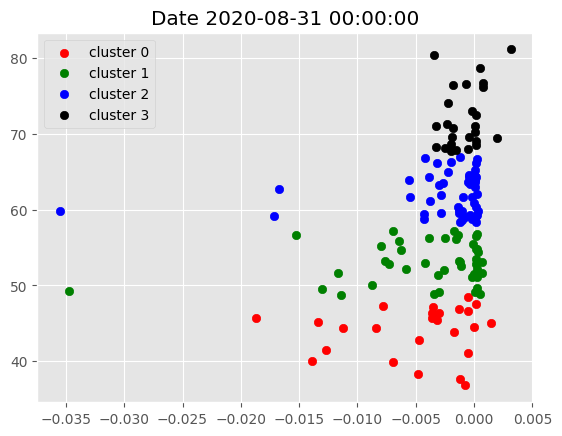

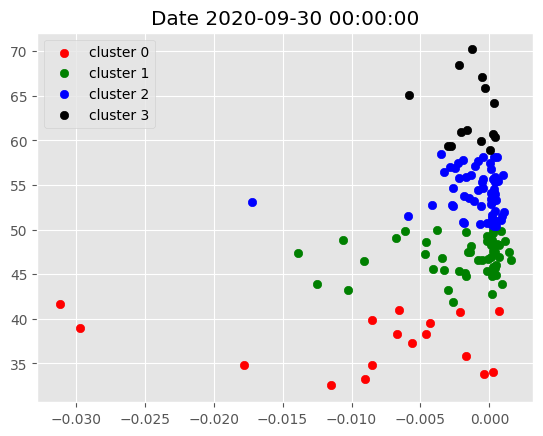

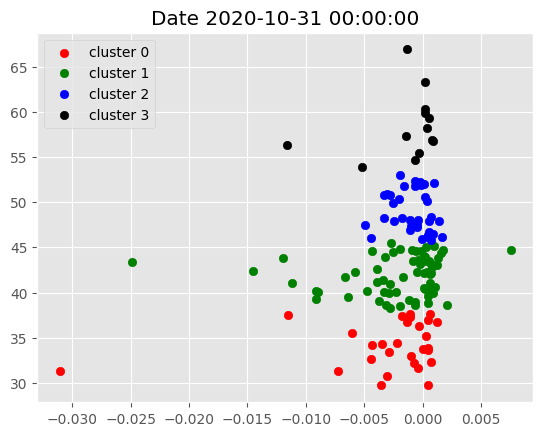

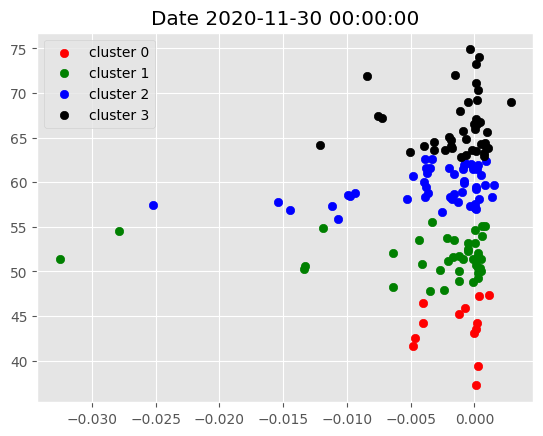

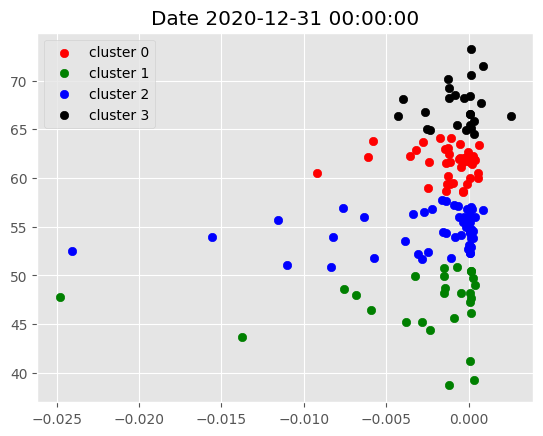

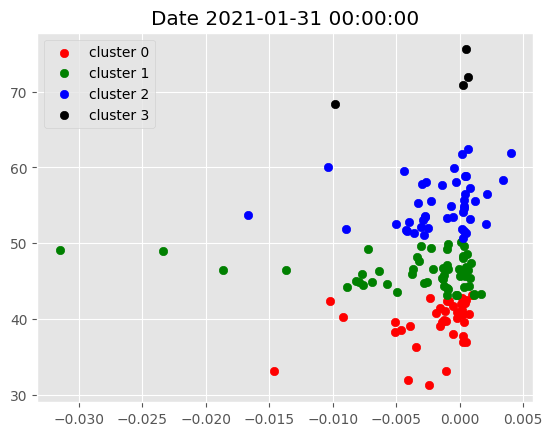

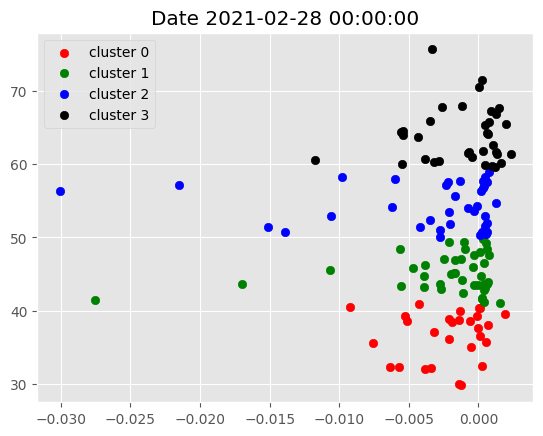

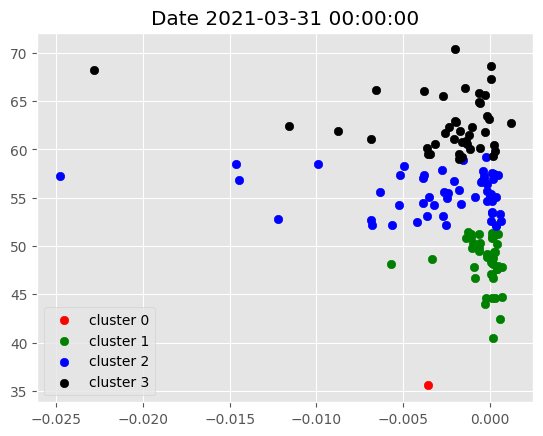

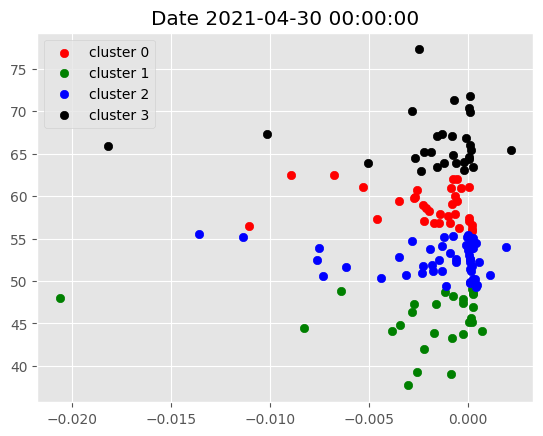

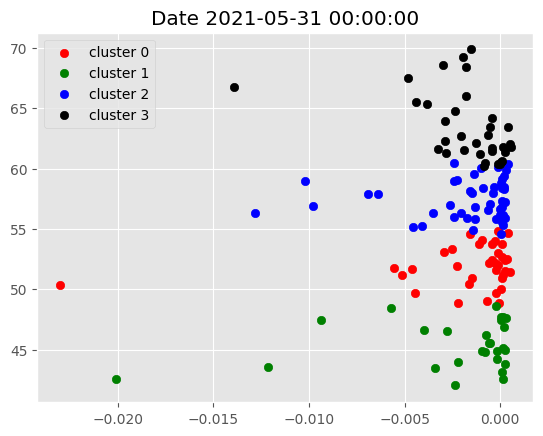

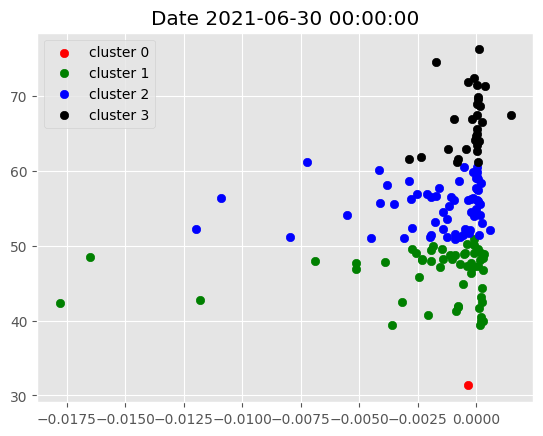

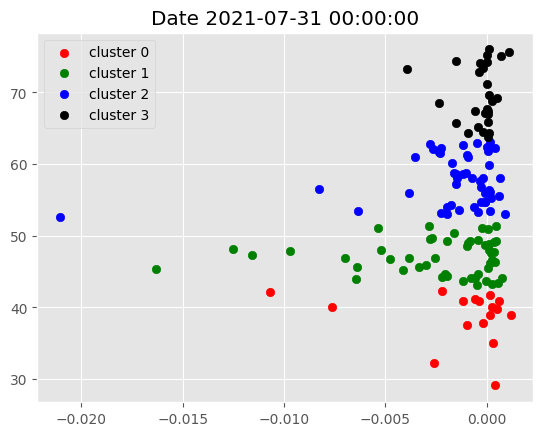

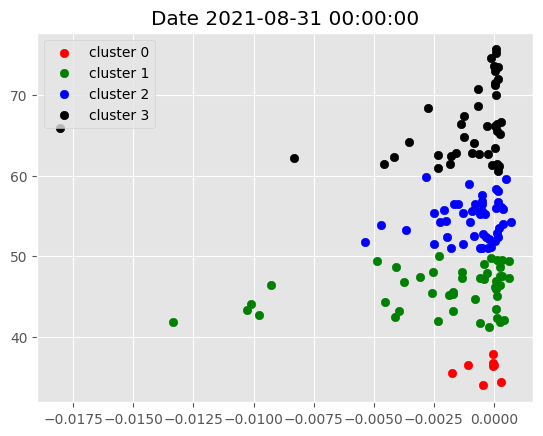

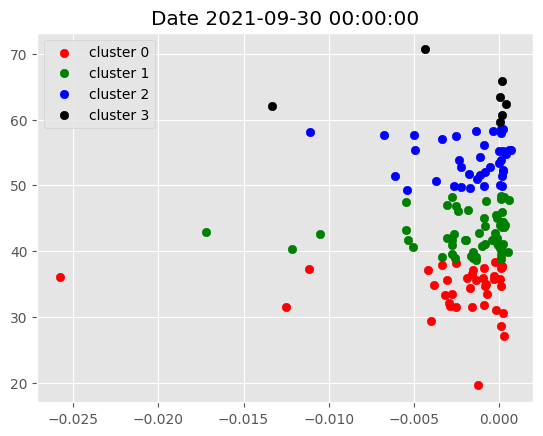

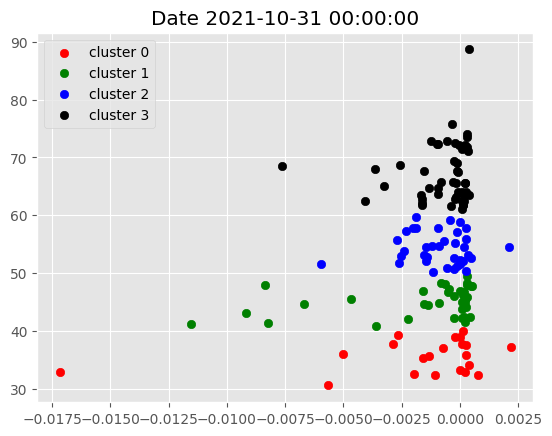

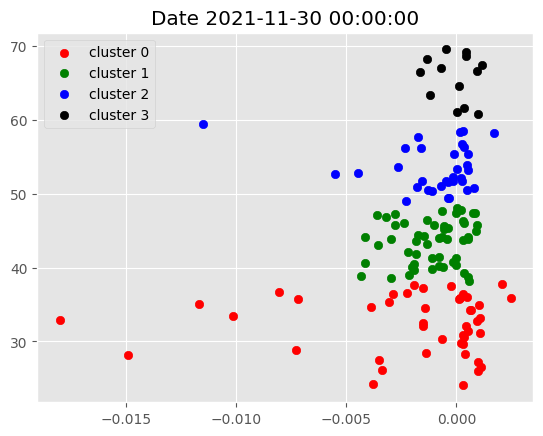

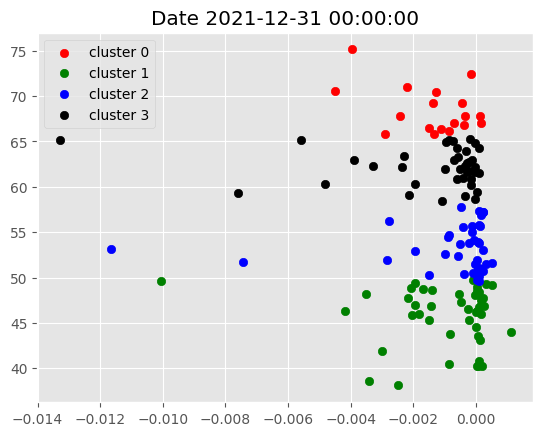

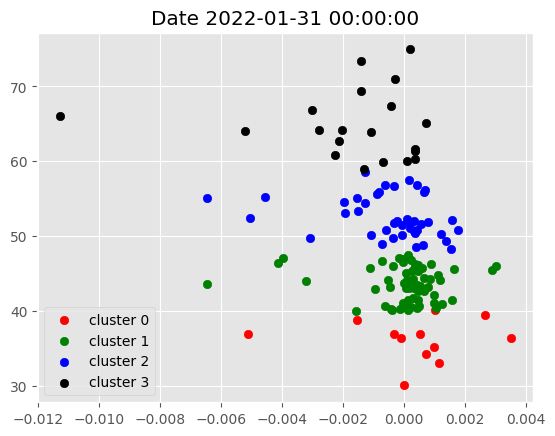

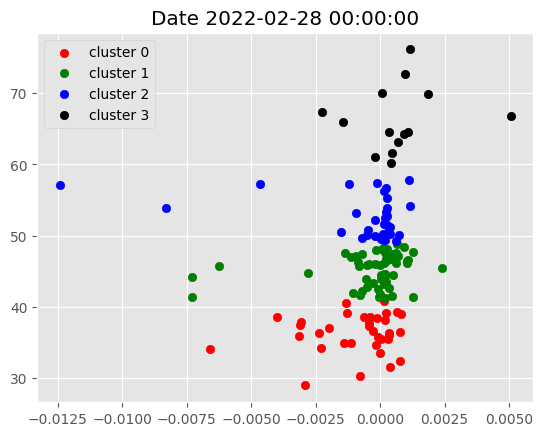

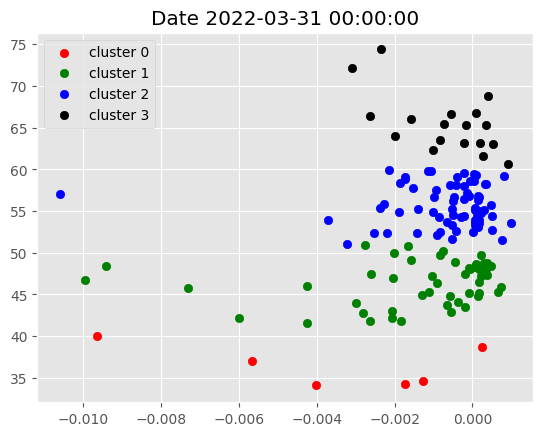

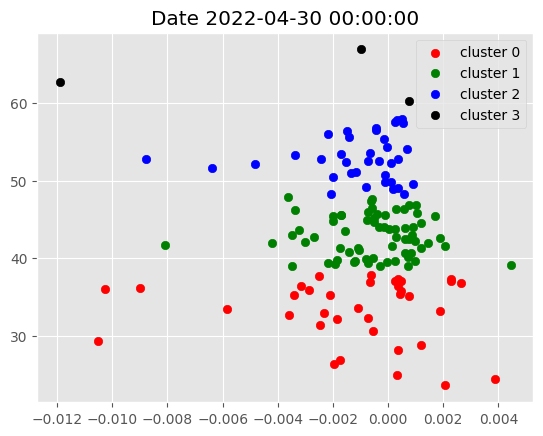

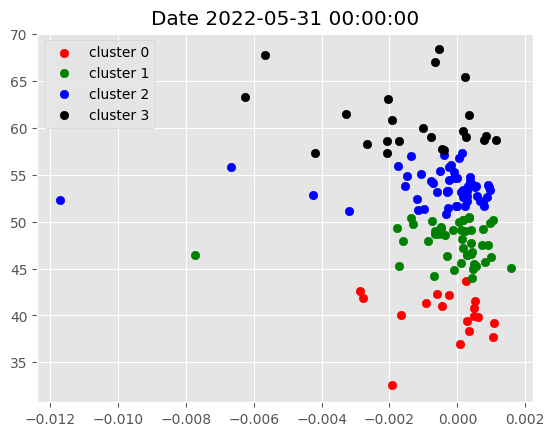

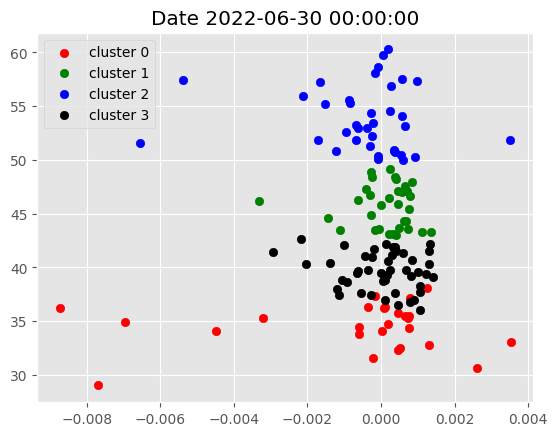

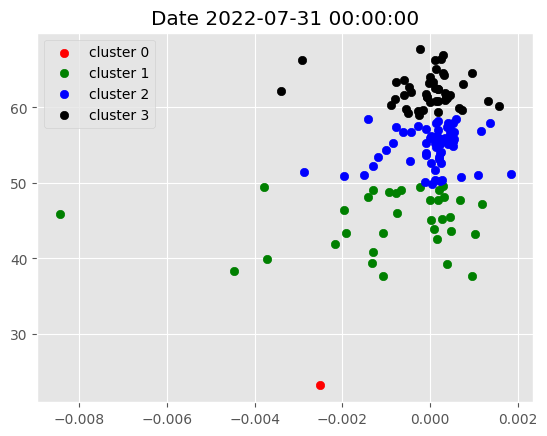

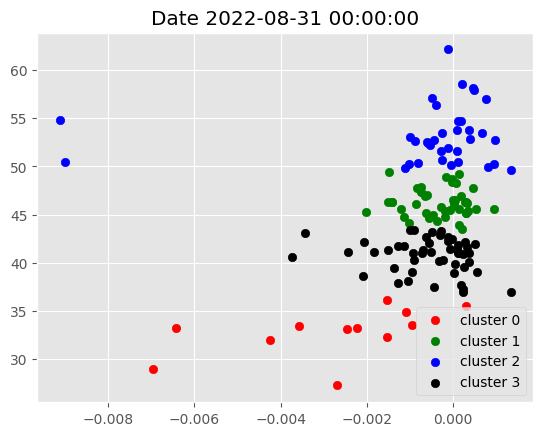

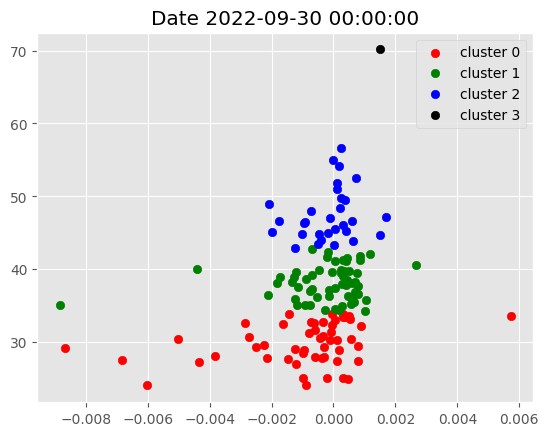

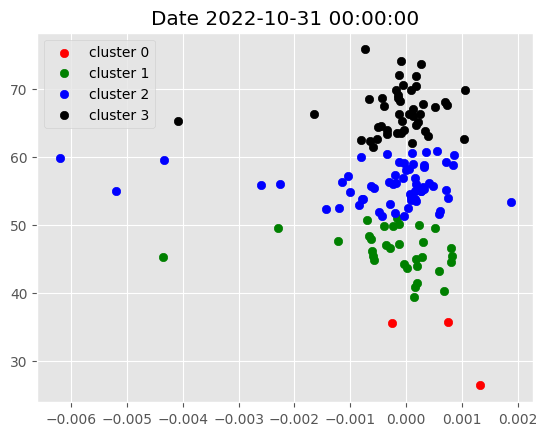

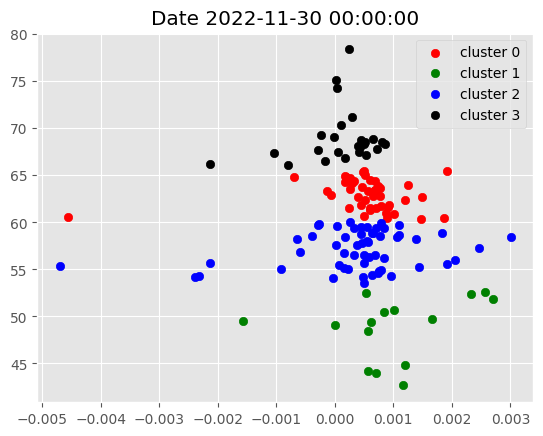

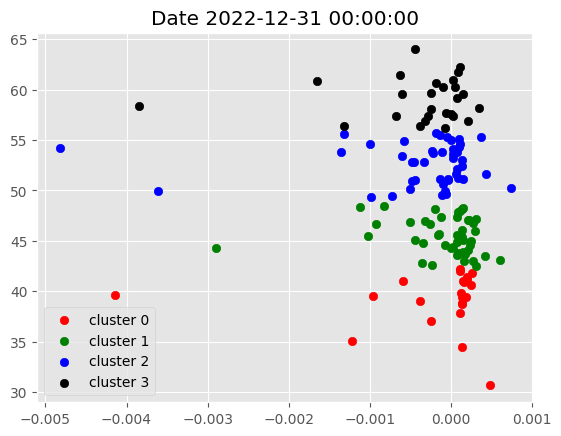

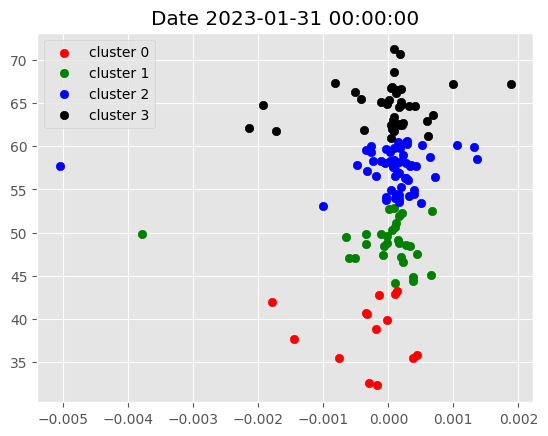

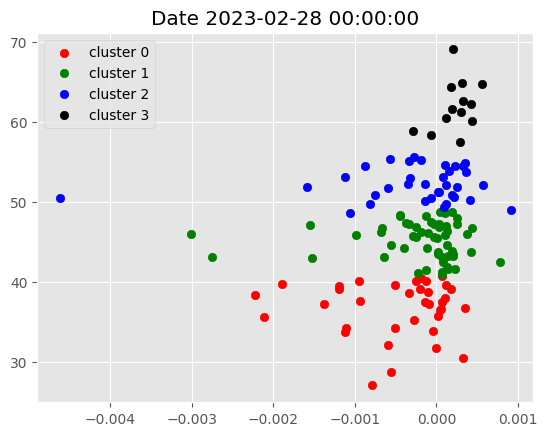

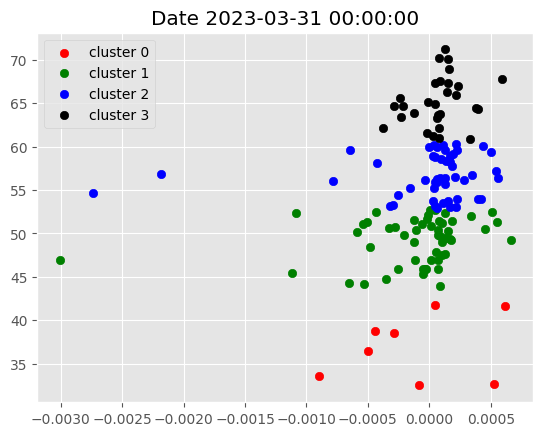

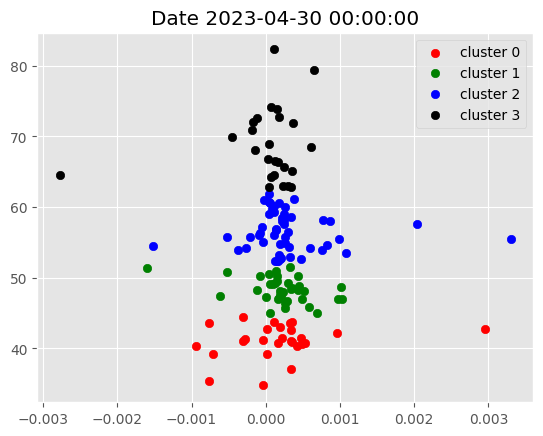

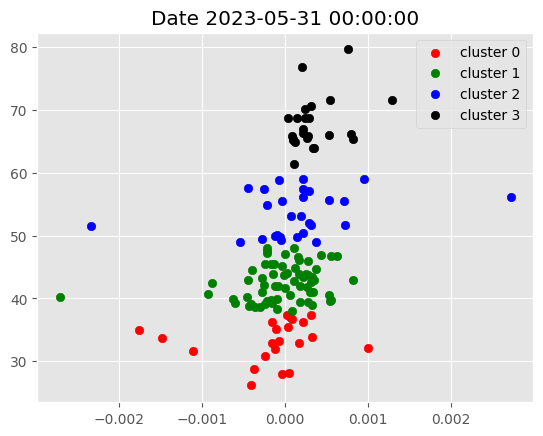

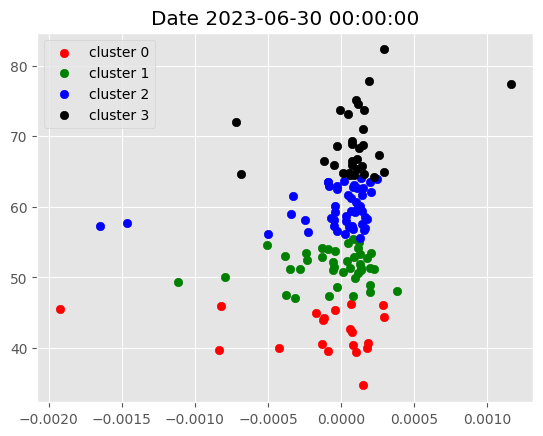

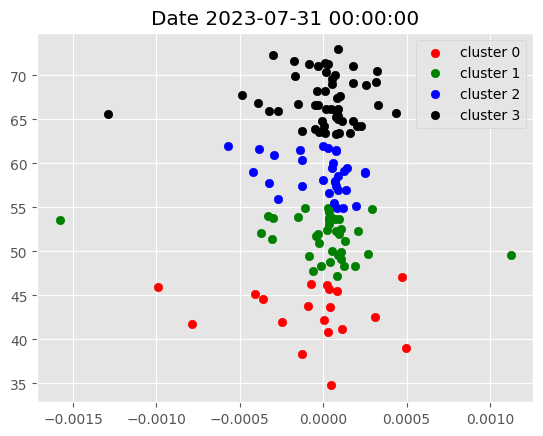

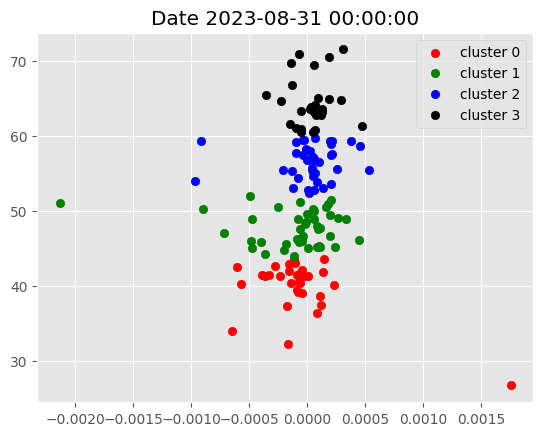

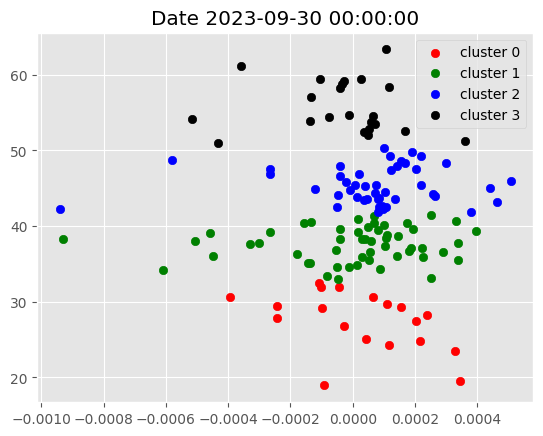

In [25]:
plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().to_list():
    g = data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [53]:
"""NOTE: For each month we select a cluster to create a portfolio based on efficient frontier max sharpe ratio optimization:
1. We first filter based on the cluster we chose
2. We select cluster 3 because they have higher RSI(70+), hence, they can outperform other clusters down the following months"""

filtered_data = data[data['cluster'] == 3].copy()
filtered_data = filtered_data.reset_index(level=1)#Hence from here we convert out dataframe to dictionary by first resetting the index
filtered_data.index = filtered_data.index + pd.DateOffset(1)
filtered_data = filtered_data.reset_index().set_index(['date','ticker'])
dates = filtered_data.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_data.xs(d,level=0).index.tolist()

fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'AD

In [27]:
#We'll define a portfolio optimisation function that minimizes the sharpe ratio, optimize the weight we'll need for 1 year prices and apply single stock weight bound constraints for diversification.
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [28]:
def optim_weights(prices,lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices,frequency=252)
    cov = risk_models.sample_cov(prices=prices,frequency=252)
    ef = EfficientFrontier(expected_returns=returns,cov_matrix=cov,weight_bounds=(lower_bound,.1),solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()

In [52]:
#Download fresh prices data
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),end=data.index.get_level_values('date').unique()[-1])

[*********************100%%**********************]  156 of 156 completed


In [30]:
new_df

Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134327   26.248032   40.245125  34.293465  103.569633   
2016-11-01  38.363209   25.774117   40.728523  34.127403  103.480522   
2016-11-02  38.276459   25.797230   40.973835  33.821526  105.681297   
2016-11-03  38.054199   25.520716   40.324486  33.541866  104.202240   
2016-11-04  38.402084   25.290670   40.432709  34.162361  104.451729   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.624222  150.264954  95.991318  313.318970   
2023-09-26  12.700000  171.514893  149.545944  94.770126  307.012848   
2023-09-27  12.610000  169.988831  148.788071  94.080750  310.739197   
2023-09-28  12.920000  170.248184  147.933029  96.631454  297.286804   
2023-09-29  12.810000  170.766830  144.833466  95.380722  303.553406   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   74.257111   72.279999  50.735889   26.654831  ...   
2016-11-01  106.870003   74.137680   70.099998  49.897141   26.489845  ...   
2016-11-02  105.889999   76.747711   68.680000  49.790253   26.205696  ...   
2016-11-03  107.169998   76.193321   67.610001  47.816727   25.912382  ...   
2016-11-04  106.199997   75.980080   69.440002  47.183552   25.866562  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  237.203583  205.669998  61.502777  136.066559  ...   
2023-09-26  506.299988  234.456207  201.660004  60.641556  133.566162  ...   
2023-09-27  502.600006  239.782974  202.279999  60.394081  134.542404  ...   
2023-09-28  504.670013  240.454971  207.889999  60.661354  137.690292  ...   
2023-09-29  509.899994  237.757019  206.910004  59.988220  137.919418  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 936 columns]

In [31]:
optimisation_df = new_df['2016-11-01':'2017-10-30']['Adj Close'][fixed_dates['2017-11-01']]
optimisation_df

Ticker,AAPL,ACN,ADBE,AMAT,AMZN,AVGO,AXP,BAC,CAT,COP,...,ORCL,PYPL,SHW,STZ,TXN,UNH,V,VLO,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-01,25.774117,103.480522,106.870003,26.489845,39.270500,132.649933,59.458363,14.064853,68.565033,34.693935,...,34.081253,41.540001,74.842522,147.406021,56.601677,124.777824,77.502647,43.356682,20.029428,58.841118
2016-11-02,25.797230,105.681297,105.889999,26.205696,38.278000,135.604660,58.740360,13.954775,67.622948,34.446918,...,33.700211,41.349998,75.417915,147.631485,56.112621,124.375099,76.515106,42.584145,20.072783,58.700428
2016-11-03,25.520716,104.202240,107.169998,25.912382,38.351501,135.942596,58.632664,13.954775,67.756340,34.741737,...,33.948338,41.189999,75.119301,144.357819,55.751316,123.345985,76.581581,42.168728,20.124809,58.848148
2016-11-04,25.290670,104.451729,106.199997,25.866562,37.752499,135.298203,58.794220,14.014050,68.623413,34.072411,...,33.921761,40.900002,75.436562,144.285507,55.505005,123.238579,76.306183,42.176006,19.988968,58.784843
2016-11-07,25.655489,106.893044,108.660004,26.883978,39.246498,139.062378,60.131466,14.403563,69.823975,34.996727,...,34.639534,41.279999,77.125458,150.017502,56.662739,127.015091,78.347755,42.649738,20.168165,60.107288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-24,36.958805,126.263794,171.580002,52.228355,48.794998,198.282135,85.594299,23.795870,118.724663,41.548145,...,44.999954,70.209999,122.296577,193.855240,80.670670,189.205627,103.704330,58.967796,26.134729,60.925411
2017-10-25,36.796482,128.308960,171.830002,51.227890,48.645500,196.793076,85.293358,23.752890,117.522285,40.708870,...,44.747852,71.019997,123.438057,193.700256,80.152054,188.669296,104.737450,58.960201,26.283255,60.706425
2017-10-26,37.031746,129.045212,173.750000,51.811501,48.621498,195.143936,87.263161,23.847454,117.608177,41.931118,...,45.153015,71.339996,124.683350,193.025681,80.428108,190.114639,105.034004,57.905182,26.324842,60.925411


In [94]:
#Calculate daily returns from our new data
#Loop through each month, select the stocks and calculate the weights for the next month
#If the maximum sharpe ratio falls on a given month, apply equally-weighted weights
#calculate eaach day given returns
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimisation_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimisation_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimisation_df = new_df[optimisation_start_date:optimisation_end_date]['Adj Close'][cols]
        success = True
        try:
            weights = optim_weights(prices=optimisation_df,lower_bound=round(1/(len(optimisation_df.columns)*2),3))
            weights = pd.DataFrame(weights,index=pd.Series(0))
            sucess = False
        except:
            print(f'Max Sharpe optimisation failed for {start_date}, continuing with equal weights')
            if success==False:
                weights = pd.DataFrame([1/len(optimisation_df.columns) for i in range(len(optimisation_df.columns))],index=optimisation_df.columns.tolist(), columns=pd.Series(0)).T
        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0).merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),left_index=True,right_index=True).reset_index().set_index(['Date', 'Ticker']).unstack().stack()
        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        temp_df  = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        portfolio_df = pd.concat([portfolio_df,temp_df],axis=0)
    except Exception as e:
        print(e)
    portfolio_df = portfolio_df.drop_duplicates()
    print(portfolio_df)

            Strategy Return
date                       
2017-11-01         0.001371
2017-11-02         0.003016
2017-11-03         0.006222
2017-11-06         0.002973
2017-11-07         0.002645
2017-11-08        -0.000816
2017-11-09        -0.008759
2017-11-10         0.004344
2017-11-13         0.002842
2017-11-14         0.001912
2017-11-15        -0.006727
2017-11-16         0.013627
2017-11-17        -0.004079
2017-11-20         0.003555
2017-11-21         0.009550
2017-11-22        -0.001847
2017-11-24         0.003721
2017-11-27        -0.001389
2017-11-28         0.005898
2017-11-29        -0.010666
2017-11-30         0.012048
            Strategy Return
date                       
2017-11-01         0.001371
2017-11-02         0.003016
2017-11-03         0.006222
2017-11-06         0.002973
2017-11-07         0.002645
2017-11-08        -0.000816
2017-11-09        -0.008759
2017-11-10         0.004344
2017-11-13         0.002842
2017-11-14         0.001912
2017-11-15        -0

In [100]:
#visualise our returns
spy = yf.download(tickers='SPY',start='2015-01-01',end=dt.date.today())
# return the log return of spy
spy_return = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'},axis=1)
portfolio_df = portfolio_df.merge(spy_return,left_index=True,right_index=True)
portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001371,0.001321
2017-11-02,0.003016,0.000388
2017-11-03,0.006222,0.003333
2017-11-06,0.002973,0.001547
2017-11-07,0.002645,-0.000696
...,...,...
2023-09-25,0.003598,0.004196
2023-09-26,-0.011647,-0.014800
2023-09-27,0.005454,0.000399
2023-09-28,0.008133,0.005781


In [102]:
plt.style.use('ggplot')

portfolio_cumm = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumm



,Strategy Return,SPY Buy&Hold
2017-11-01,0.001371,0.001321
2017-11-02,0.004391,0.001710
2017-11-03,0.010640,0.005049
2017-11-06,0.013645,0.006603
2017-11-07,0.016327,0.005903
...,...,...
2023-09-25,0.972045,0.642492
2023-09-26,0.949076,0.618183
2023-09-27,0.959706,0.618828
2023-09-28,0.975645,0.628186


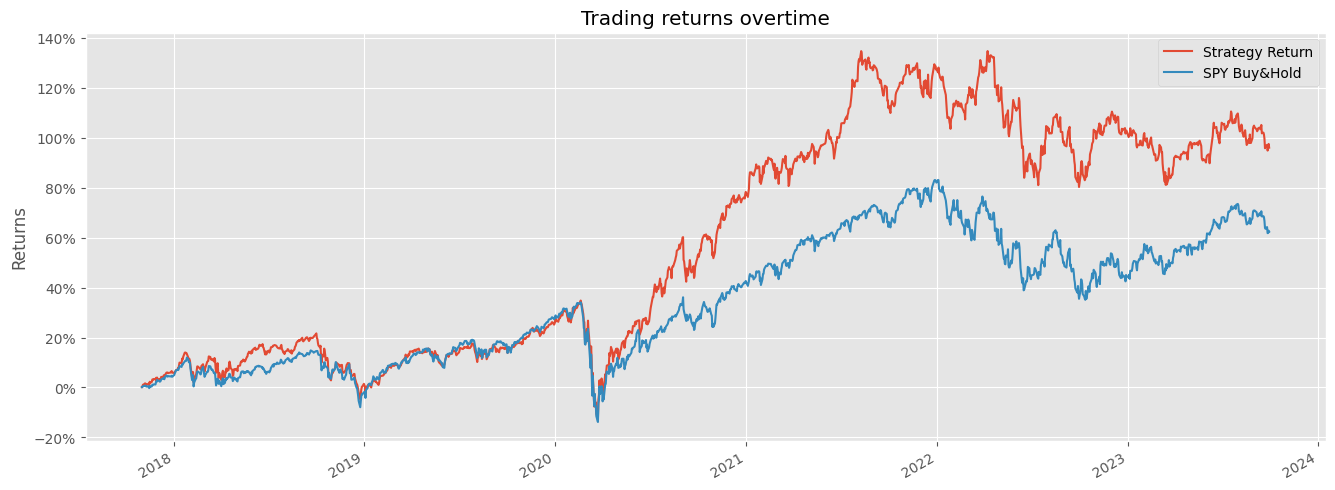

In [104]:
#plot the graph 
import matplotlib.ticker as mtick
portfolio_cumm[:'2023-09-29'].plot(figsize=(16,6))
plt.title('Trading returns overtime')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Returns')
plt.show()